In [5]:
import time
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# Step 1: Load the dataset
print("Fetching MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

# Step 2: Normalize the data
print("Normalizing data...")
X = X / 255.0  # Scale pixel values to [0, 1]

# Step 3: Select 10,000 samples randomly for training
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=10000, random_state=42)
print(f"Reduced dataset size: {len(X_subset)}")

# Step 4: Standardize the features (not necessary for Naive Bayes, but kept for consistency)
scaler = StandardScaler()
X_subset = scaler.fit_transform(X_subset)

# Step 5: Define the Naive Bayes model
print("Applying 10-fold cross-validation with Naive Bayes...")
nb_clf = GaussianNB()

# Step 6: Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_scores = []

start_time = time.time()
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_subset, y_subset), 1):
    # Split the data for the current fold
    X_train, X_test = X_subset[train_idx], X_subset[test_idx]
    y_train, y_test = y_subset[train_idx], y_subset[test_idx]

    # Train the model
    nb_clf.fit(X_train, y_train)

    # Evaluate the model
    score = nb_clf.score(X_test, y_test)
    fold_scores.append(score)
    print(f"Fold {fold_idx}: Accuracy: {score * 100:.2f}%")

end_time = time.time()

# Step 7: Report overall results
print(f"\nCross-validation completed in {end_time - start_time:.2f} seconds.")
print(f"Accuracy for each fold: {[f'{score * 100:.2f}%' for score in fold_scores]}")
print(f"Mean accuracy: {np.mean(fold_scores) * 100:.2f}%")
print(f"Standard deviation: {np.std(fold_scores) * 100:.2f}%")


Fetching MNIST dataset...
Normalizing data...
Reduced dataset size: 10000
Applying 10-fold cross-validation with Naive Bayes...
Fold 1: Accuracy: 60.40%
Fold 2: Accuracy: 58.50%
Fold 3: Accuracy: 54.10%
Fold 4: Accuracy: 56.20%
Fold 5: Accuracy: 58.10%
Fold 6: Accuracy: 54.50%
Fold 7: Accuracy: 53.20%
Fold 8: Accuracy: 56.10%
Fold 9: Accuracy: 57.30%
Fold 10: Accuracy: 55.70%

Cross-validation completed in 1.64 seconds.
Accuracy for each fold: ['60.40%', '58.50%', '54.10%', '56.20%', '58.10%', '54.50%', '53.20%', '56.10%', '57.30%', '55.70%']
Mean accuracy: 56.41%
Standard deviation: 2.09%


In [1]:
import time
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Function to calculate log of Beta distribution (for stability)
def beta_log_likelihood(x, alpha, beta, epsilon=1e-10):
    # Clip x values to avoid log(0) and numerical issues
    x = np.clip(x, epsilon, 1 - epsilon)
    log_likelihood = (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)
    return log_likelihood

# Step 1: Load the dataset
print("Fetching MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

# Step 2: Normalize the data
print("Normalizing data...")
X = X / 255.0  # Scale pixel values to [0, 1]

# No data reduction (use the full dataset)
print(f"Dataset size: {len(X)}")

# Step 3: Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 4: Naive Bayes with Beta Distribution
print("Applying 10-fold cross-validation with Naive Bayes...")
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_scores = []
start_time = time.time()

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    # Split the data for the current fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Step 5: Calculate alpha and beta for each feature and each class
    alpha = np.zeros((10, X_train.shape[1]))  # 10 classes, one alpha vector for each class
    beta = np.zeros((10, X_train.shape[1]))   # 10 classes, one beta vector for each class

    for class_idx in range(10):
        # Get the training data for the current class
        class_data = X_train[y_train == class_idx]
        
        for i in range(X_train.shape[1]):  # For each feature
            feature_train = class_data[:, i]
            mean = np.mean(feature_train)
            var = np.var(feature_train)
            
            # Avoid division by zero by checking if variance is zero
            if var == 0:
                alpha[class_idx, i] = 1.0
                beta[class_idx, i] = 1.0
            else:
                alpha[class_idx, i] = (mean * (1 - mean)) / var
                beta[class_idx, i] = ((1 - mean) * mean) / var

    # Step 6: Calculate the likelihoods for the test set and predict the class
    log_likelihoods = np.zeros((X_test.shape[0], 10))  # Stores likelihoods for each class

    for i in range(X_test.shape[0]):
        sample = X_test[i]
        
        for class_idx in range(10):
            sample_likelihood = 0
            for j in range(len(sample)):
                sample_likelihood += beta_log_likelihood(sample[j], alpha[class_idx, j], beta[class_idx, j])
            log_likelihoods[i, class_idx] = sample_likelihood

    # Step 7: Make prediction (class with highest log-likelihood)
    predicted_class = np.argmax(log_likelihoods, axis=1)
    accuracy = np.mean(y_test == predicted_class)
    fold_scores.append(accuracy)

    print(f"Fold {fold_idx}: Accuracy: {accuracy * 100:.2f}%")

end_time = time.time()

# Step 8: Report overall results
print(f"\nCross-validation completed in {end_time - start_time:.2f} seconds.")
print(f"Accuracy for each fold: {[f'{score * 100:.2f}%' for score in fold_scores]}")
print(f"Mean accuracy: {np.mean(fold_scores) * 100:.2f}%")
print(f"Standard deviation: {np.std(fold_scores) * 100:.2f}%")


Fetching MNIST dataset...
Normalizing data...
Dataset size: 70000
Applying 10-fold cross-validation with Naive Bayes...
Fold 1: Accuracy: 9.74%
Fold 2: Accuracy: 9.74%
Fold 3: Accuracy: 9.74%
Fold 4: Accuracy: 9.74%
Fold 5: Accuracy: 9.74%
Fold 6: Accuracy: 9.01%
Fold 7: Accuracy: 9.03%
Fold 8: Accuracy: 11.24%
Fold 9: Accuracy: 11.24%
Fold 10: Accuracy: 9.01%

Cross-validation completed in 3294.45 seconds.
Accuracy for each fold: ['9.74%', '9.74%', '9.74%', '9.74%', '9.74%', '9.01%', '9.03%', '11.24%', '11.24%', '9.01%']
Mean accuracy: 9.83%
Standard deviation: 0.77%


Mean of pixel intensities: 0.1309
Standard Deviation of pixel intensities: 0.3084
Alpha (α) for Beta distribution: 1.1960
Beta (β) for Beta distribution: 1.1960

Sample pixel values (first 10):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


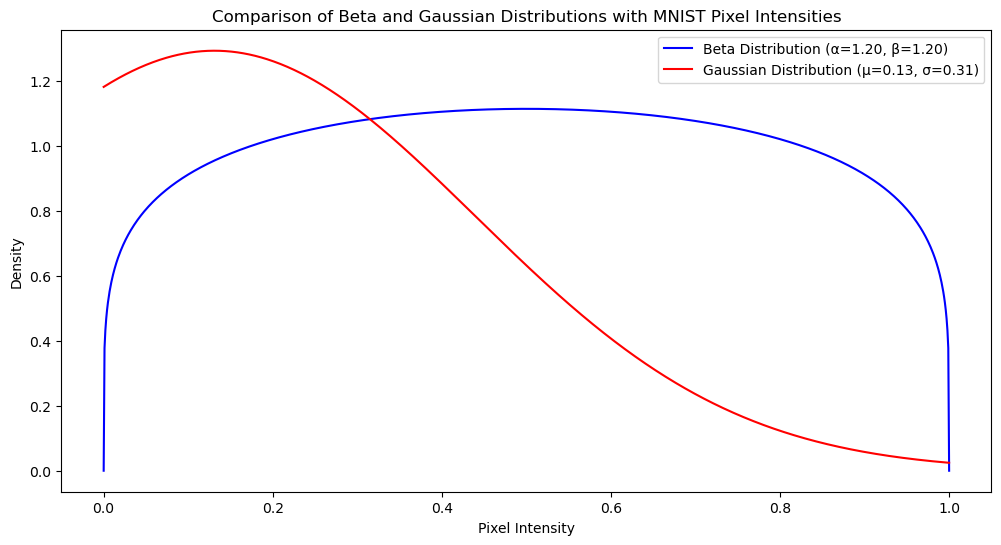

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, beta

# Fetch the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Normalize the data (scale pixel values to [0, 1])
X = X / 255.0

# Flatten all images into a single array to visualize the distribution of all pixel values
all_pixels = X.flatten()

# Calculate mean and variance for Gaussian distribution
mean = np.mean(all_pixels)
std_dev = np.std(all_pixels)

# Calculate alpha and beta for Beta distribution using the method described
alpha = (mean * (1 - mean)) / (std_dev ** 2)
beta_param = (1 - mean) * (mean) / (std_dev ** 2)

# Generate points for the x-axis (pixel intensities)
x = np.linspace(0, 1, 1000)

# Print key statistics
print(f"Mean of pixel intensities: {mean:.4f}")
print(f"Standard Deviation of pixel intensities: {std_dev:.4f}")
print(f"Alpha (α) for Beta distribution: {alpha:.4f}")
print(f"Beta (β) for Beta distribution: {beta_param:.4f}")

# Print some sample pixel values (first 10)
print("\nSample pixel values (first 10):")
print(all_pixels[:10])

# Plot the histogram of pixel intensities
plt.figure(figsize=(12, 6))

# Plot the histogram of pixel intensities
# plt.hist(all_pixels, bins=50, range=(0, 1), color='green', alpha=0.7, density=True, label='Pixel Intensities')

# Plot Beta distribution with the calculated parameters
plt.plot(x, beta.pdf(x, alpha, beta_param), color='blue', label=f'Beta Distribution (α={alpha:.2f}, β={beta_param:.2f})')

# Plot Gaussian distribution with the calculated mean and std deviation
plt.plot(x, norm.pdf(x, mean, std_dev), color='red', label=f'Gaussian Distribution (μ={mean:.2f}, σ={std_dev:.2f})')

# Add titles and labels
plt.title('Comparison of Beta and Gaussian Distributions with MNIST Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


In [5]:
# prior probabilities

import numpy as np
from sklearn.datasets import fetch_openml
from collections import Counter
from sklearn.metrics import accuracy_score
# Step 1: Load the MNIST dataset
print("Fetching MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

X = X / 255.0
y = y.astype(int)  # Convert labels to integers

# Step 2: Calculate the total number of samples
total_samples = len(y)
# Step 3: Count the number of samples for each class
class_counts = Counter(y)

# Step 4: Calculate the class prior probabilities P(C_k)
class_priors = {class_label: count / total_samples for class_label, count in class_counts.items()}

# Step 5: Display the class prior probabilities
print("Class Prior Probabilities:")
for class_label, prior in class_priors.items():
    print(f"P(C_{class_label}) = {prior:.4f}")


# Step 3: Define a function to calculate alpha and beta for Beta distribution
def compute_alpha_beta(X_class):
    # For each feature (pixel) in the dataset, compute the mean and variance
    alpha = []
    beta = []
    
    # Compute alpha and beta for each feature (pixel) for the given class
    for i in range(X_class.shape[1]):  # Loop over all features (784 features for MNIST)
        feature_data = X_class[:, i]  # Data for the ith feature (pixel)
        
        # Compute the mean and variance for this feature
        mean = np.mean(feature_data)
        variance = np.var(feature_data)
        
        # Avoid division by zero by checking if variance is zero
        if variance == 0:
            alpha_i = 1.0
            beta_i = 1.0
        else:
            # Use the method of moments to estimate alpha and beta
            k = mean * (1 - mean) / variance
            alpha_i = mean * k
            beta_i = (1 - mean) * k
        
        alpha.append(alpha_i)
        beta.append(beta_i)
    
    return np.array(alpha), np.array(beta)

# Step 4: Compute alpha and beta for all classes (0 to 9)
alpha_dict = {}
beta_dict = {}

for class_label in range(10):  # Loop over all class labels (0 to 9)
    # Extract the data for the current class
    class_data = X[y == class_label]
    
    # Compute alpha and beta for the current class
    alpha, beta = compute_alpha_beta(class_data)
    
    # Store the results in dictionaries
    alpha_dict[class_label] = alpha
    beta_dict[class_label] = beta

# # Step 5: Print the results for one of the classes (e.g., class '0')
# print(f"Alpha for class 0 (first 10 values): {alpha_dict[0][:10]}")  # First 10 values of alpha
# print(f"Beta for class 0 (first 10 values): {beta_dict[0][:10]}")    # First 10 values of beta

# Optional: Print the summary for all classes
for class_label in range(10):
    print(f"Class {class_label}: Alpha (mean) = {np.mean(alpha_dict[class_label]):.2f}, "
          f"Beta (mean) = {np.mean(beta_dict[class_label]):.2f}")


def predict_class(sample, alpha_dict, beta_dict, class_priors):
    max_log_prob = -np.inf
    predicted_class = -1
    epsilon = 1e-10  # Small constant to avoid log(0)
    # Ensure x is between 0 and 1 (normalize)
    sample = np.clip(sample, epsilon, 1 - epsilon)  # Clip values to avoid log(0) or log(1)
    for class_label in range(10):
        alpha = alpha_dict[class_label]
        beta = beta_dict[class_label]
        
        # Compute log-likelihood for the class
        log_likelihoods = (alpha - 1) * np.log(sample) + (beta - 1) * np.log(1 - sample)
        total_log_prob = np.sum(log_likelihoods) + np.log(class_priors[class_label])
        
        if total_log_prob > max_log_prob:
            max_log_prob = total_log_prob
            predicted_class = class_label

    return predicted_class

# # Pick a test sample (let's pick the first one from the test set)
# test_sample = X[0]
# actual_label = y[0]

# X_normalized = X / 255.0

# print(f"Min value in normalized data: {X_normalized.min()}")
# print(f"Max value in normalized data: {X_normalized.max()}")

# # Normalize the test sample to the range [0, 1]
# # test_sample = test_sample / 255.0

# # # Reshape the test sample for visualization (28x28 image)
# test_sample_image = test_sample.reshape(28, 28)

# # # Plot the image
# plt.imshow(test_sample_image, cmap='gray')
# plt.title(f"Actual Label: {actual_label}")
# plt.show()

# # # Make a prediction using the Naive Bayes classifier
# predicted_class = predict_class(X_normalized, alpha_dict, beta_dict, class_priors)

# # # Print the prediction result
# print(f"Predicted Class: {predicted_class}")


# Step 7: Predict for all test samples and calculate accuracy
# predictions = []
# for test_sample in X_test:
#     predicted_class = predict_class(test_sample, alpha_dict, beta_dict, class_priors)
#     predictions.append(predicted_class)

# Step 8: Calculate accuracy
# accuracy = accuracy_score(y_test, predictions)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Optional: To visualize the first test sample and its prediction
# test_sample_image = X_test[0].reshape(28, 28)
# plt.imshow(test_sample_image, cmap='gray')
# plt.title(f"Predicted Label: {predictions[0]}, Actual Label: {y_test[0]}")
# plt.show()

Fetching MNIST dataset...
Class Prior Probabilities:
P(C_5) = 0.0902
P(C_0) = 0.0986
P(C_4) = 0.0975
P(C_1) = 0.1125
P(C_9) = 0.0994
P(C_2) = 0.0999
P(C_3) = 0.1020
P(C_6) = 0.0982
P(C_7) = 0.1042
P(C_8) = 0.0975
Class 0: Alpha (mean) = 0.51, Beta (mean) = 1.38
Class 1: Alpha (mean) = 0.37, Beta (mean) = 2.71
Class 2: Alpha (mean) = 0.41, Beta (mean) = 1.37
Class 3: Alpha (mean) = 0.44, Beta (mean) = 1.83
Class 4: Alpha (mean) = 0.40, Beta (mean) = 2.01
Class 5: Alpha (mean) = 0.41, Beta (mean) = 1.42
Class 6: Alpha (mean) = 0.47, Beta (mean) = 1.42
Class 7: Alpha (mean) = 0.40, Beta (mean) = 1.75
Class 8: Alpha (mean) = 0.49, Beta (mean) = 1.35
Class 9: Alpha (mean) = 0.47, Beta (mean) = 1.73


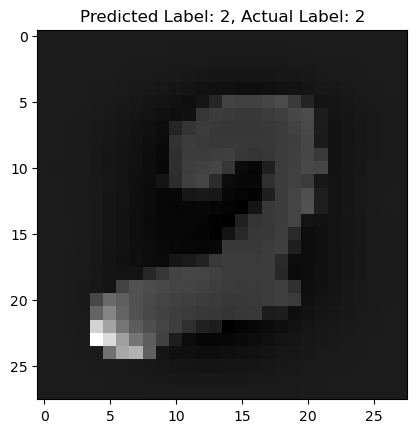

In [103]:
# Optional: To visualize the first test sample and its prediction
test_sample_image = X_test[3232].reshape(28, 28)
plt.imshow(test_sample_image, cmap='gray')
plt.title(f"Predicted Label: {predictions[3232]}, Actual Label: {y_test[3232]}")
plt.show()